In [2]:
import gym

import tensorflow as tf
from tensorflow import keras

import cv2

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
env_name = "CarRacing-v0"
env = gym.make(env_name)

env.seed(42)
np.random.seed(42)

C:\Users\antol\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
print('Observation Space:', env.observation_space)
print('Action Space:', env.action_space)

Observation Space: Box(0, 255, (96, 96, 3), uint8)
Action Space: Box(-1.0, 1.0, (3,), float32)


In [4]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, inputs):
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)
        inputs = inputs.astype(float)
        inputs /= 255.0
        inputs = inputs[0:80, :]
        inputs = np.expand_dims(inputs, axis=-1)
        return inputs

In [8]:
# arg 0 : steering angle (-1 to 1)
# arg 1 : velocity (0 to 1)
# arg 2 : braking (0 to 1)

def naive_policy(i):
    action = env.action_space.sample()
    if i > 200 :
        action[0] = 0
        action[1] = 1
        action[2] = 0.8
    return action

Track generation: 1208..1514 -> 306-tiles track
5
Sum of rewards: 6.05737704918033


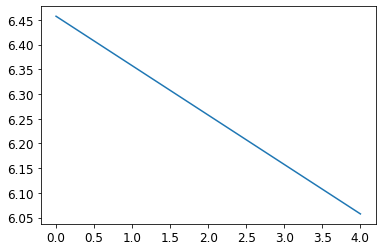

In [9]:
w_env = ObservationWrapper(env)

def demonstration(policy):
    observation = env.reset()
    i=0
    sum_rewards=[]

    for _ in range(5):
        env.render()
        action = policy(i)
        image_sample, reward, done, info = w_env.step(action)  
        i+=1
        sum_rewards.append(reward)
        if done: 
            break;

    print(i)
    print('Sum of rewards:', np.sum(sum_rewards))
    plt.plot(np.cumsum(sum_rewards))
    env.close()
    
    return image_sample

image_sample = demonstration(policy = naive_policy)

(96, 96, 1)


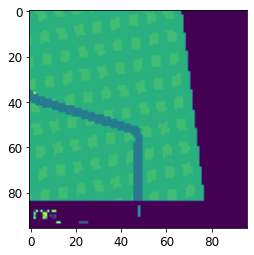

In [11]:
print(image_sample.shape)
plt.imshow(image_sample)

In [20]:
model = keras.models.Sequential([
keras.layers.Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(96, 96, 1)), 
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Conv2D(filters=12, kernel_size=(4, 4), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Flatten(),
keras.layers.Dense(24, activation='relu'),
keras.layers.Dense(5, activation='softmax')])

model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.05))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 6)         300       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 12)        1164      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 12)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                10392     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

In [43]:
model.predict(image_sample[np.newaxis])

array([[0.21547857, 0.20390072, 0.2001847 , 0.18102048, 0.19941553]],
      dtype=float32)

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [6]:
def render_policy_net(env, model, action_space, seed=42):
        frames = []
        env.seed(seed)
        np.random.seed(seed)
        obs = env.reset()
        negative_reward_counter=0
        for step in range(1000):
            frames.append(env.render(mode="rgb_array"))
            action_probas = model(obs[np.newaxis])
            print('action_probas', action_probas)
            p=tf.squeeze(action_probas).numpy()
            p /= np.sum(p)
            action = np.random.choice(range(5), p=p)
            print('action', action)
            obs, reward, done, info = env.step(action_space[action])
            if reward < 0:
                negative_reward_counter +=1
            else :
                negative_reward_counter = 0
            if done or negative_reward_counter > 75 :
                break
        env.close()
        return frames

# Reinforce PG

In [3]:
class ReinforceAgent:
    def __init__(self,
        env,
        action_space = [[-1,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]],
        n_frame_stack = 4,
        limit = 100,
        discount_rate = 0.99,
        optimizer = keras.optimizers.Adam(lr=1e-2),
        n_episodes_per_update = 5,
        loss_fn = keras.losses.categorical_crossentropy
    ):
        self.env             = env
        self.action_space    = action_space
        self.n_actions       = len(action_space)
        self.n_frame_stack   = n_frame_stack
        self.limit           = limit
        self.discount_rate   = discount_rate
        self.optimizer       = optimizer
        self.model           = self.build_model()
        self.n_episodes_per_update = n_episodes_per_update
        self.loss_fn = loss_fn

    def build_model(self):
        model = keras.models.Sequential([
            ####### concatenate x images#######
        keras.layers.Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(96, 96, 1)), 
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=12, kernel_size=(4, 4), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(self.n_actions, activation='softmax')])
        
        return model

    def play_one_step(self, obs):
        with tf.GradientTape() as tape:
            action_probas = self.model(obs[np.newaxis])
            #print('action_probas', action_probas)
            p=tf.squeeze(action_probas).numpy()
            p /= np.sum(p)
            #print('p', p)
            action = np.random.choice(range(5), p=p)
            #print('action', action)
            y_target = tf.one_hot(action[np.newaxis],5)
            #print('target',y_target)
            loss = tf.reduce_mean(self.loss_fn(y_target, action_probas))
        grads = tape.gradient(loss, self.model.trainable_variables)
        obs, reward, done, info = self.env.step(self.action_space[action])
        return obs, reward, done, grads, loss
            

    def play_multiple_episodes(self):        
        all_rewards = []
        all_grads = []
        all_losses = []
        for episode in range(self.n_episodes_per_update):            
            negative_reward_counter = 0
            
            current_rewards = []
            current_grads = []
            current_losses = []
            
            n_steps = []
            
            obs = self.env.reset()
            for step in range(1000):
                obs, reward, done, grads, loss = self.play_one_step(obs)
                if reward < 0 :
                    negative_reward_counter += 1
                else :
                    negative_reward_counter = 0
                    
                current_rewards.append(reward)
                current_grads.append(grads)
                current_losses.append(loss)
                
                if done or negative_reward_counter > self.limit :
                    break
                    
            n_steps.append(step)        
            all_rewards.append(current_rewards)
            
            all_grads.append(current_grads)
            all_losses.append(current_losses)
            
        return all_rewards, all_grads, all_losses, n_steps
    
    def discount_rewards(self, rewards, discount_rate):
        discounted = np.array(rewards)
        for step in range(len(rewards) - 2, -1, -1):
            discounted[step] += discounted[step + 1] * discount_rate
        return discounted
    
    def discount_and_normalize_rewards(self, all_rewards, discount_rate):
        all_discounted_rewards = [self.discount_rewards(rewards, discount_rate)
                                  for rewards in all_rewards]
        flat_rewards = np.concatenate(all_discounted_rewards)
        reward_mean = flat_rewards.mean()
        reward_std = flat_rewards.std()
        return [(discounted_rewards - reward_mean) / reward_std
                for discounted_rewards in all_discounted_rewards]
    

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [14]:
mean_rewards = []
all_mean_losses = []
all_mean_steps = []

w_env = ObservationWrapper(env)
agent = ReinforceAgent(w_env)

agent.load('models/RPG')

for iteration in range(10):
    
    all_rewards, all_grads, all_losses, n_steps = agent.play_multiple_episodes()
    
    total_rewards = sum(map(sum, all_rewards))
    mean_reward = total_rewards / agent.n_episodes_per_update
    mean_rewards.append(mean_reward)
    mean_steps = np.mean(n_steps)
    all_mean_steps.append(mean_steps)
    
    mean_loss = np.mean(np.concatenate(all_losses))
    all_mean_losses.append(mean_loss)
    
    print("\rIteration: {}, mean rewards: {:.1f}, mean steps: {:.1f}".format(iteration, mean_reward, mean_steps), end="")
    all_final_rewards = agent.discount_and_normalize_rewards(all_rewards, agent.discount_rate)
    all_mean_grads = []
    
    for var_index in range(len(agent.model.trainable_variables)):
        
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        
        all_mean_grads.append(mean_grads)
        
    agent.optimizer.apply_gradients(zip(all_mean_grads, agent.model.trainable_variables))
    agent.save('models/RPG')

w_env.close()

Track generation: 1203..1508 -> 305-tiles track
Track generation: 1127..1413 -> 286-tiles track
Iteration: 0, mean rewards: 44.1, mean steps: 175.0Track generation: 1237..1550 -> 313-tiles track
Track generation: 1129..1416 -> 287-tiles track
Iteration: 1, mean rewards: 50.3, mean steps: 185.0Track generation: 1177..1475 -> 298-tiles track
Track generation: 1048..1318 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1236..1549 -> 313-tiles track
Iteration: 2, mean rewards: 50.4, mean steps: 185.0Track generation: 1243..1558 -> 315-tiles track
Track generation: 1131..1418 -> 287-tiles track
Iteration: 3, mean rewards: 51.6, mean steps: 185.0Track generation: 1157..1451 -> 294-tiles track
Track generation: 1147..1438 -> 291-tiles track
Iteration: 4, mean rewards: 53.4, mean steps: 185.0Track generation: 1037..1307 -> 270-tiles track
Track generation: 1011..1271 -> 260-tiles track
retry to generate track (normal if there 

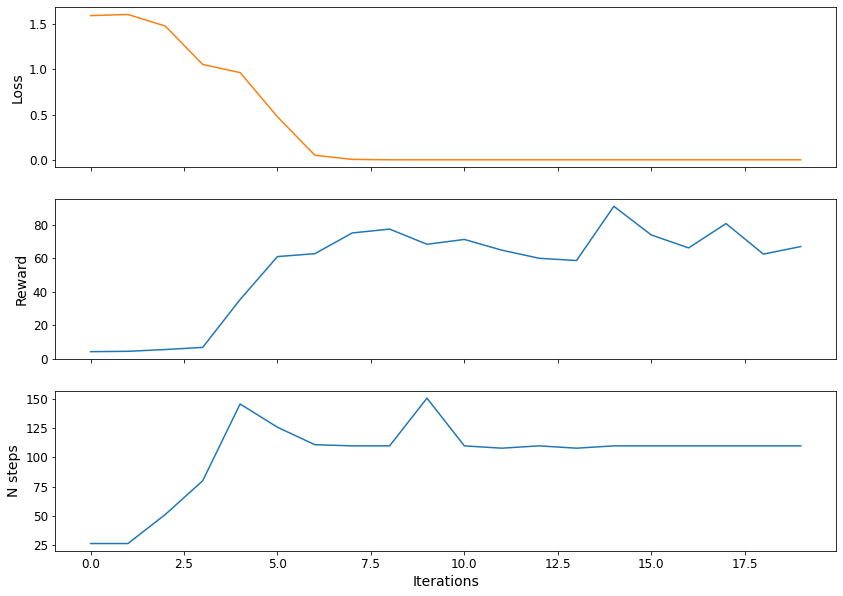

In [9]:
fig, ax = plt.subplots(3,sharex=True)
fig.set_figheight(10)
fig.set_figwidth(14)
ax[0].plot(all_mean_losses,  'tab:orange')
ax[1].plot(mean_rewards)
ax[2].plot(all_mean_steps)

ax[0].set(ylabel='Loss')
ax[1].set(ylabel='Reward')
ax[2].set(xlabel='Iterations', ylabel='N steps')
plt.show()

In [15]:
frames = render_policy_net(agent.env, agent.model, agent.action_space)
plot_animation(frames)

Track generation: 1208..1514 -> 306-tiles track
action_probas tf.Tensor([[5.543493e-35 0.000000e+00 3.854562e-32 1.000000e+00 0.000000e+00]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3


action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_probas tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float32)
action 3
action_

In [14]:
env.close()